# BBC News Classification
This project is a part of a Kaggle Competition: BBC News Classification (https://www.kaggle.com/c/learn-ai-bbc/overview) that uses both supervised and unsupervised methods to predict the topic of various BBC news articles. The different models are then compared and the one with the highest accuracy score is used to create a solution that will then be submitted to the Kaggle competition.

Load in the necessary libaries

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix

_________
## Load in Data
Load in the csv's that came from the Kaggle page. This includes test and train data, as well as a sample solution set

In [24]:
sample_solution = pd.read_csv('BBC_News_Sample_Solution.csv')
test_unlabeled = pd.read_csv('BBC_News_Test.csv')
train_full = pd.read_csv('BBC_News_Train.csv')

The sample solution shows an example of the solution to be submitted. This includes a dataframe of the Category associated with each Article ID.

In [25]:
sample_solution

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics
...,...,...
730,1923,sport
731,373,tech
732,1704,business
733,206,entertainment


Look into some of the features of the training data, like number of entries, categories, and get a quick look at some of the first entries.

In [26]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [27]:
train_full.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [28]:
test_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [29]:
test_unlabeled.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


Check for any duplicate data.

In [30]:
train_full.duplicated(subset=['Text']).sum()

np.int64(50)

Looks like there are 50 rows of duplicated data. So we can now drop the duplicated data.

In [31]:
train_full = train_full.drop_duplicates(subset=['Text'])

Check for any null values in the data.

In [32]:
train_full.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

We can add a column for word count to get an idea of the number of words in each article.

Text(0.5, 1.0, 'Word Count Distribution by Category')

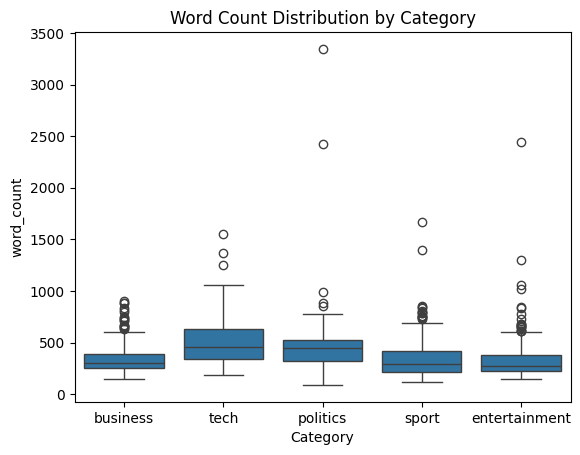

In [33]:
train_full['word_count'] = train_full['Text'].str.split().apply(len)
plt.figure()
sns.boxplot(data = train_full, x = 'Category', y = 'word_count')
plt.title('Word Count Distribution by Category')

It looks like word count is fairly constant across categories, with a few outliers but nothing noticeable to affect results.

Next thing to look at is the distribution of the different categories to see if there is any class imbalance.

Text(0.5, 1.0, 'Category Spread')

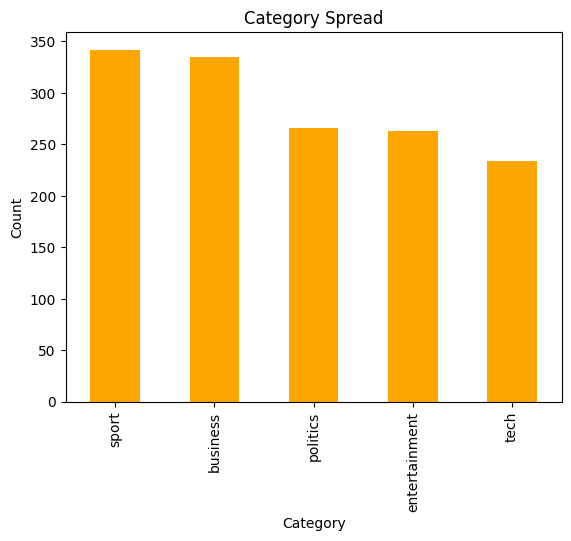

In [34]:
train_full['Category'].value_counts().plot(kind = 'bar', color = 'orange')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Spread')

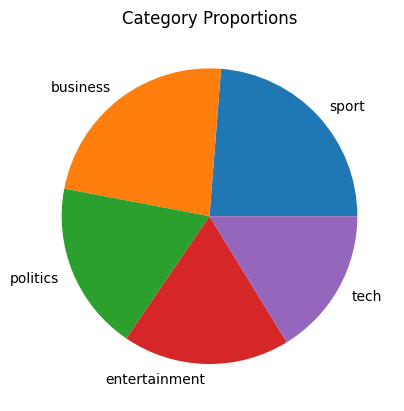

In [35]:
train_full['Category'].value_counts().plot(kind = 'pie')
plt.title('Category Proportions')
plt.ylabel('')
plt.show()

Sport and business have more articles attributed to those categories, but there is not a dramatic imbalance of classes. This is useful to know going forward, and we don't need to adjust for any class imbalance.

Now to split the full training data into train and validation data, to test out the models before final submission on the final test data.

In [36]:
train, val = train_test_split(
    train_full, 
    test_size = 0.2,  # 20% for validation
    random_state = 123,
    stratify = train_full['Category']  # split balanced across the categories
)


__________

## Data Cleaning and Organizing

Use TF-IDF (Term Frequency - Inverse Document Frequency) to process the text data into matrix form. This method works by multiplying a term's **term frequency** with it's **inverse document frequency**. The **term frequency (TF)** is calculated by taking the number of times a term appears in a document and dividing that by the total number of terms in the document:

$$ TF = \frac{\text{number of times term appears in document}}{\text{number of terms in document}} $$

The **inverse document frequency (IDF)** is found by taking the log of the total number of documents, divided by the number of documents containing the term:

$$ IDF = \log{\frac{\text{number of documentst}}{\text{number of documents containing the term}}}$$

The TF-IDF is just these two terms multiplied together:

$$ \text{TF-IDF} = TF * IDF $$

This is a popular approach to word embedding because it looks at word frequency while also taking into consideration the fact that some words are just very common in many documents and gives those words less weight than the ones that really define what a text is about. This is an especially good method to use as the data being analyzed here contains a lot of text data and a variety of categories, giving an accurate spread of common words across those categories.

This is a **bag of words** approach because it considers frequency of words, but not the order they are used in.

Sklearn has a class called TfidfVectorizer, which converts text data into matrix form using this method.

In [37]:
vectorizer = TfidfVectorizer(min_df = 50, max_df = 0.9, ngram_range = (1, 2), stop_words = 'english')

**min_df** = minimum number of documents a word needs to appear in to be included \
**max_df** = maximum percent of documents that a term can appear in to be included \
**ngram_range** = include terms that are made of 1 or 2 words (i.e. bank account) \
**stop_words** = language of stop words, removes common words like and, the, is, etc.

In [38]:
X_train = vectorizer.fit_transform(train['Text'])
X_val = vectorizer.transform(val['Text'])
X_test = vectorizer.transform(test_unlabeled['Text'])
X_train_full = vectorizer.fit_transform(train_full['Text'])

y_train = train['Category']
y_val = val['Category']
y_train_full = train_full['Category']

features = vectorizer.get_feature_names_out()

_______
## Modeling
Time to try out a few different models and see which one works best with this data. First try unsupervised methods, and can later try supervised.
### Unsupervised Learning - Matrix Factorization
#### Non-Negative Matrix Factorization (NMF)
Use Non-Negative Matrix Factorization on the data to break down the TF-IDF matrix into 2 matrices: W (basis matrix) and H (coefficient matrix), both with non-negative entries. This is applicable to this data since the TF-IDF matrix is non-negative. NMF can utilize different solvers and loss functions. The loss functions Kullback-Leibler or Itakura-Saito are sensitive to 0 values in the data, which this data does have, so these will be skipped. 

This method can be performed on the **full** train data, since the labels associated with the text are not actually being used to train the model. It is only in supervised methods that the test and train data must be split up.

n_components is set to 5 as we already know we want to classify the data into one of 5 categories.

In [39]:
# Coordinate Descent
nmf_cd = NMF(n_components = 5, random_state = 123, solver = 'cd', beta_loss = 'frobenius')
W_cd = nmf_cd.fit_transform(X_train_full) # basis matrix
H_cd = nmf_cd.components_ # coefficient matrix
top_topics_cd = W_cd.argmax(axis = 1)

for topic_idx, topic in enumerate(H_cd):
    top_word_idx = topic.argsort()[:-10-1:-1]
    top_words = [features[i] for i in top_word_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: said, growth, year, market, sales, firm, company, economy, bank, shares
Topic 2: mr, labour, blair, election, party, said, brown, government, mr blair, minister
Topic 3: game, england, win, cup, said, players, play, wales, team, match
Topic 4: film, best, awards, actor, award, films, oscar, director, star, won
Topic 5: people, mobile, said, music, technology, phone, users, software, net, use


The top terms for each topic, shown above, can be used to then map the assigned topics to the actual topics.

In [40]:
topic_mapping = {
    0: 'business',
    1: 'politics',
    2: 'sport',
    3: 'entertainment',
    4: 'tech'
}

categories_cd = [topic_mapping[topic] for topic in top_topics_cd]

In [41]:
print(classification_report(y_train_full, categories_cd))

               precision    recall  f1-score   support

     business       0.96      0.86      0.91       335
entertainment       0.96      0.63      0.76       263
     politics       0.87      0.88      0.87       266
        sport       0.94      0.98      0.96       342
         tech       0.66      0.96      0.78       234

     accuracy                           0.87      1440
    macro avg       0.88      0.86      0.86      1440
 weighted avg       0.89      0.87      0.87      1440



This model, with **Coordinate Descent** as the solver and **Frobenius** as the loss function, gives an accuracy score of 0.87. The same process can be done using the **Multiplicative Update** solver, to see if this outputs a better result.

In [65]:
# Multiplicative Update
nmf_mu = NMF(n_components = 5, random_state = 123, solver = 'mu', beta_loss = 'frobenius')
W_mu = nmf_mu.fit_transform(X_train_full) # basis matrix
H_mu = nmf_mu.components_ # coefficient matrix
top_topics_mu = W_mu.argmax(axis = 1)

for topic_idx, topic in enumerate(H_mu):
    top_word_idx = topic.argsort()[:-10-1:-1]
    top_words = [features[i] for i in top_word_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: said, year, growth, firm, market, company, sales, economy, 2004, bank
Topic 2: mr, labour, blair, election, party, said, brown, government, mr blair, minister
Topic 3: game, england, win, cup, said, players, play, wales, team, match
Topic 4: film, best, awards, actor, award, films, oscar, director, star, won
Topic 5: people, mobile, said, music, technology, phone, users, software, net, use


It looks like the **Multiplicative Update** model mapped similar words to the same topics, so the same mapping can be used.

In [64]:
categories_mu = [topic_mapping[topic] for topic in top_topics_mu]

print(classification_report(y_train_full, categories_mu))

               precision    recall  f1-score   support

     business       0.87      0.91      0.89       335
entertainment       0.96      0.67      0.79       263
     politics       0.90      0.84      0.87       266
        sport       0.93      0.99      0.96       342
         tech       0.74      0.94      0.83       234

     accuracy                           0.88      1440
    macro avg       0.88      0.87      0.87      1440
 weighted avg       0.89      0.88      0.87      1440



The NMF model using **Multiplicative Update** as the solver and **Frobenius** as the loss function gives a slightly higher accuracy, of 0.88. 

#### Hyperparameter Tuning
Aside from solvers and loss functions, there are other **hyperparameters** that can be modified to slightly improve the model. The following shows the results from adjusting various hyperparameters in the NMF model with MU and Frobenius. The hyperparameters adjusted include:

**max_iter**: the maximum number of times the algorithm will iterate\
**l1_ratio**: ratio of L1 and L2 regularization in loss function (0 = L2 regularization, 1 = L1 regularization)\
**init**: initialization method

| Hyperparameter                      | Accuracy (%) |
|----------------------------|--------------|
| **max_iter = 200 (default)** |     88     |
| **max_iter = 50** |      88    |
| **l1_ratio = 0**  |       88     |
| **l1_ratio = 1**  |       88      |
| **init = 'nndsvdar'**  |       87   |
| **init = 'random'**  |       50   |

This hyperparameter tuning did not affect the accuracy much which is a sign that the model is either converging too quickly, or is already well-optimized for this data. As it turns out, the default parameters for max_iter, l1_ratio, and init already gave the best accuracy score.

This data can now be used to create a **confusion matrix** to visualize which categories are being predicted correctly or not.

Text(50.72222222222221, 0.5, 'True Categories')

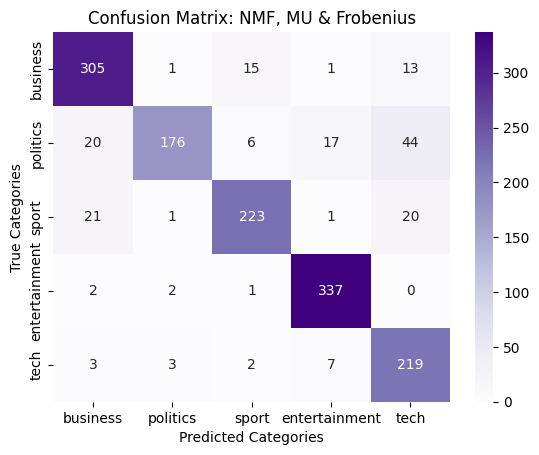

In [57]:
cm = confusion_matrix(y_train_full, categories_mu)
plt.figure()
sns.heatmap(cm, annot = True, fmt = 'g', cmap = 'Purples', xticklabels = topic_mapping.values(), yticklabels = topic_mapping.values())
plt.title('Confusion Matrix: NMF, MU & Frobenius')
plt.xlabel('Predicted Categories')
plt.ylabel('True Categories')

The confusion matrix shows that there are some categories that the model predicted well, and others that it did not predict as well. For example, articles not about politics where rarely cast as political articles, however, many political articles were mislabeled as other categories. This might be happening because words associated with politics may often show up in other articles. An opposite example of this is entertainment. Entertainment articles were rarely mislabeled, but other articles, specifically politics, were sometimes mislabeled as entertainment. This is likely because many articles include vocabulary that could be interpreted as part of multiple labels, and some articles are hard to put into a  single category, even by humans.

_______
### Supervised Learning
This section predicts article labels with the use of **supervised learning**, but making use of the labels that come with the training data. This requires using the train and validation **subsets** of the train_full data to avoid data leaking, as labels are now being input into the model.

### Multinomial Naive Bayes (MNM)
This model is often useful when trying to classify text, with features representinve term frequencies in a document.

In [59]:
MNM = MultinomialNB()
MNM.fit(X_train, y_train)

print(classification_report(y_val, MNM.predict(X_val)))

               precision    recall  f1-score   support

     business       0.98      0.91      0.95        67
entertainment       1.00      0.92      0.96        53
     politics       0.94      0.96      0.95        53
        sport       0.94      1.00      0.97        68
         tech       0.84      0.91      0.88        47

     accuracy                           0.94       288
    macro avg       0.94      0.94      0.94       288
 weighted avg       0.95      0.94      0.94       288



### Random Forest Classifier (RFC)
This method puts together multiple decision trees and does a good job of reducing overfitting.

In [60]:
RFC = RandomForestClassifier(n_estimators = 50, random_state = 123)
RFC.fit(X_train, y_train)

print(classification_report(y_val, RFC.predict(X_val)))

               precision    recall  f1-score   support

     business       0.90      0.93      0.91        67
entertainment       0.89      0.96      0.93        53
     politics       0.96      0.89      0.92        53
        sport       0.92      0.99      0.95        68
         tech       0.90      0.77      0.83        47

     accuracy                           0.91       288
    macro avg       0.91      0.91      0.91       288
 weighted avg       0.91      0.91      0.91       288



### Support Vector Machine (SVM)
SVM attempts to find the best hyperplane to separate classes with high dimensions.

In [61]:
SVM = SVC(kernel = 'linear')
SVM.fit(X_train, y_train)

print(classification_report(y_val, SVM.predict(X_val)))

               precision    recall  f1-score   support

     business       0.96      0.96      0.96        67
entertainment       0.98      0.96      0.97        53
     politics       0.98      0.91      0.94        53
        sport       0.96      1.00      0.98        68
         tech       0.92      0.96      0.94        47

     accuracy                           0.96       288
    macro avg       0.96      0.96      0.96       288
 weighted avg       0.96      0.96      0.96       288



Text(50.722222222222214, 0.5, 'True Categories')

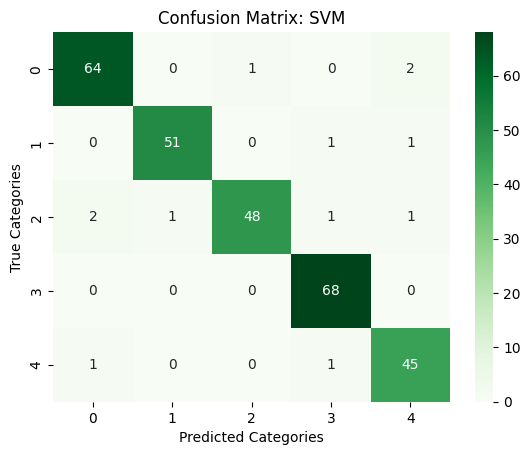

In [62]:
cm = confusion_matrix(y_val, SVM.predict(X_val))
plt.figure()
sns.heatmap(cm, annot = True, fmt = 'g', cmap = 'Greens')
plt.title('Confusion Matrix: SVM')
plt.xlabel('Predicted Categories')
plt.ylabel('True Categories')

________
## Model Evaluation

The Kaggle competition looks at **accuracy** so this is the value to focus on when comparing models.

| Model                      | Supervised/Unsupervised | Accuracy (%) |
|----------------------------|-------------------------|--------------|
| **NMF with CB, Frobenius** |       Unsupervised      |      87      |
| **NMF with MU, Frobenius** |       Unsupervised      |      88      |
| **MNM**  |       Supervised      |      94     |
| **RFC**  |       Supervised      |      91      |
| **SVM, Linear Kernel**  |       Supervised      |      96      |


From the models trained, the supervised models seemed to do better than the unsupervised models, likely because of the subjectivity of classifying some articles that may fit into multiple categories, which is improved by including labels. Between the supervised methods, **Support Vector Machine** gave the highest accuracy score of 96%. This is understandable as this model is particularly good at dealing with data with high dimensions, which text classification often has.

Now that the model with the highest accuracy is chosen, SVM can be used to create a solution that will be submitted to the Kaggle competition, following the format of sample_solution.

In [63]:
solution = pd.DataFrame()
test_unlabeled.head()

categories = SVM.predict(X_test)
solution['ArticleId'] = test_unlabeled['ArticleId']
solution['Category'] = categories

solution

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,politics
733,206,business


In [64]:
solution.to_csv('solution.csv', index = False)

_______
## References
Problem-solving with ML: automatic document classification - Google Cloud

https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification

TF-IDF — Term Frequency-Inverse Document Frequency

https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/

Sklearn feature_extraction - Tf–idf term weighting

https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

